In [1]:
import sys
import glob
import numpy as np
import xarray as xr
import pandas as pd
import datetime as dt
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.cm as cm
from scipy.interpolate import griddata
from scipy.io import savemat

import netCDF4
from netCDF4 import Dataset

import geocat.viz.util as gvutil

sys.path.append('/glade/work/ndietrich/Supplementary_Functions/')
import HelperFunctions as hp # Kinda janky way to add these functions, should make it a package but lazy

/glade/u/home/bdilorenzo/anaconda3/envs/NOAA/lib/python3.10/site-packages/geocat/viz/cmaps.py:9: DeprecationWarning: geocat.viz.cmaps is deprecated, use cmaps instead
  warnings.warn("geocat.viz.cmaps is deprecated, use cmaps instead",


In [2]:
#Read in files
folderpath_tgcm = '/glade/scratch/bdilorenzo/GDC/tiegcm_files/'
folderpath_sat = '/glade/scratch/bdilorenzo/GDC/orbit_files/'

sat_filepath = folderpath_sat + 'gdc_drm_ephem_g1_allphases.ncdf'

sat1_file = Dataset(sat_filepath)


In [3]:
# Time
time_e = np.asarray(sat1_file.variables['elapsed_time']) #elapsed time in days
time_elapsed = (time_e - time_e[0])*24*60*60 #elapsed time in seconds

t1 = dt.datetime(2013,3,17,0,0)

time = []
for i in range(len(time_elapsed)):
    time.append(t1 + dt.timedelta(seconds=int(time_elapsed[i])))

time = np.array(time)

i_reg = np.where(time_e == 291)[0][0]
i_glo = np.where(time_e == 764)[0][0]

time_loc = time[0:i_reg] #Phase 1
time_reg = time[i_reg:i_glo] #Phase 2
time_glo = time[i_glo:] #Phase 3

#Phase 2a: 291
#Phase 3a: 426
#Phase 3b: 764


t_h = np.array(dt.datetime(2013,3,18,0,0,0))
i_d = int(np.where(time_loc >= t_h)[0][0])

t_h3 = np.array(dt.datetime(2014,2,16,0,0,0))
i_d3 = int(np.where(time_glo >= t_h3)[0][0])

time_h = time_loc[0:i_d] #First hour of Phase 1
time_h3a = time_glo[0:i_d]
time_h_round = []
time_h_check = pd.date_range(time_h[0], time_h[-1], periods=len(time_h)).to_pydatetime()

for t in time_h_check:
    if t.second >= 30:
        time_h_round.append(t.replace(second=0).replace(microsecond=0) + dt.timedelta(minutes=1))
    else:
        time_h_round.append(t.replace(second=0).replace(microsecond=0))

time_h_round = np.array(time_h_round)

i_h1 = 122




[datetime.datetime(2015, 1, 19, 0, 0) datetime.datetime(2015, 1, 19, 0, 0)
 datetime.datetime(2015, 1, 19, 0, 0, 32)
 datetime.datetime(2015, 1, 19, 0, 0, 56)
 datetime.datetime(2015, 1, 19, 0, 1, 28)
 datetime.datetime(2015, 1, 19, 0, 2)
 datetime.datetime(2015, 1, 19, 0, 2, 28)
 datetime.datetime(2015, 1, 19, 0, 3)
 datetime.datetime(2015, 1, 19, 0, 3, 28)
 datetime.datetime(2015, 1, 19, 0, 4, 4)]


Text(0.5, 1.0, 'Orbital Paths for First Hour')

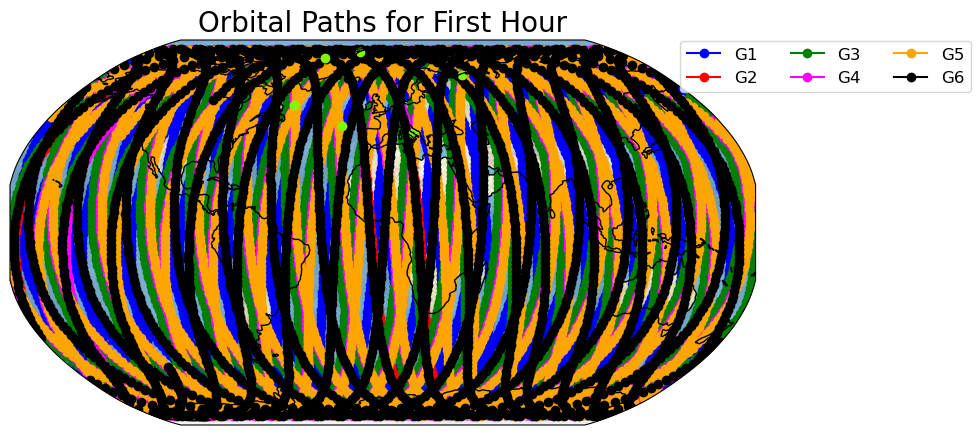

In [4]:
# Grab all satellite orbits and plot

satellites = [1,2,3,4,5,6]

sat_labels = ['G1','G2','G3','G4','G5','G6']
sat_colors = ['blue','red','green','magenta','orange','black']


Lat = np.zeros((6,len(time_e)))
Lon = np.zeros((6,len(time_e)))
Alt = np.zeros((6,len(time_e)))

c = 0
for s in satellites:
    satellite_filepath = folderpath_sat + 'gdc_drm_ephem_g' + str(s) + '_allphases.ncdf'
    satellite_file = Dataset(satellite_filepath)

    Lat[c,:] =  np.asarray(satellite_file.variables['geod_lat'])
    Lon[c,:] =  np.asarray(satellite_file.variables['geod_lon'])
    Alt[c,:] =  np.asarray(satellite_file.variables['geod_alt'])

    c += 1


# lat_loc = Lat[:,0:i_reg] #Phase 1
# lon_loc = Lon[:,0:i_reg]

# lat = lat_loc[:,0:i_d] #Day 1
# lon = lon_loc[:,0:i_d]
# alt = Alt[:,0:i_d]

lat_3a = Lat[:,i_glo:] #Phase 1
lon_3a = Lon[:,i_glo:]
alt_3a = Alt[:,i_glo:]

lat = lat_3a[:,0:i_d] #Day 1
lon = lon_3a[:,0:i_d]
alt = alt_3a[:,0:i_d]

lon = lon - 180

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

# make the map global rather than have it zoom in to
# the extents of any plotted data
ax.set_global()
ax.set_extent([180,-180,-90,90], ccrs.PlateCarree())
ax.stock_img()
ax.coastlines()

for i in range(0,len(satellites)):
    ax.scatter(lon[i,:],lat[i,:],color = sat_colors[i],transform = ccrs.PlateCarree())
ax.scatter(lon[:,0],lat[:,0],color='lawngreen',transform=ccrs.PlateCarree())

legend_elements = [Line2D([0], [0], marker='o', color=sat_colors[s], label=sat_labels[s]) 
                    for s in range(0,len(satellites))]
plt.legend(handles=legend_elements,fontsize='large',bbox_to_anchor =(1.3, 1.02),ncol=3)
plt.title('Orbital Paths for Day',fontsize=20)

# plt.savefig('satellite_orbits_hour1.png')



In [5]:
# TIEGCM Files
tt1 = dt.datetime(2013,3,17,0,1)
tt2 = dt.datetime(2013,3,18,0,0)
timespan = np.arange(tt1, tt2, dt.timedelta(minutes=1)).astype(dt.datetime)

# Select which variable to look at
vars = ['DEN','TN','UN','VN','O2','O1','NO','NE','TE','OP']
nvars = len(vars)
# total density, neutral temp, neutral zonal wind, neutral meridional wind, molecular oxygen,...
# atomic oxygen, nitric oxide, electron density, electron temp, o+ ion
a = 8


files = len(glob.glob1(folderpath_tgcm,"*.nc"))

DEN = np.zeros((files*60,57,144,288))
O2 = np.zeros((files*60,57,144,288))
O1 = np.zeros((files*60,57,144,288))
ZG_total = np.zeros((files*60,57,144,288))
for k in range(0,files):
    if k == 23:
        tgcm_filepath = folderpath_tgcm + '13Ma_sech_tie_2013-03-17T' + "{0:02d}".format(k) + '-01-00_2013-03-18T00-00-00.nc'
    else:
        tgcm_filepath = folderpath_tgcm + '13Ma_sech_tie_2013-03-17T' + "{0:02d}".format(k) + '-01-00_2013-03-17T' + "{0:02d}".format(k+1) + '-00-00.nc'

    tgcm_file = Dataset(tgcm_filepath)
    DEN[k*60:(k+1)*60,:,:,:] =  np.asarray(tgcm_file.variables['DEN'])
    O2[k*60:(k+1)*60,:,:,:] =  np.asarray(tgcm_file.variables['O2'])
    O1[k*60:(k+1)*60,:,:,:] =  np.asarray(tgcm_file.variables['O1'])
    ZG_total[k*60:(k+1)*60,:,:,:] =  np.asarray(tgcm_file.variables['ZG'])*(1e-5) #km

# np.savetxt('tgcm_' + vars[a] + '.txt',var)
# np.savetxt('tgcm_ZG.txt',ZG_total)


# temp_n = tgcm_file['TN'].values
Lat_T =  np.asarray(tgcm_file.variables['lat'])
Lon_T =  np.asarray(tgcm_file.variables['lon'])
# ilev = tgcm_file['ilev'].values
# ZG = tgcm_file['ZG'].values *(1e-5) #km


/glade/scratch/bdilorenzo/ipykernel_54155/3784388141.py:27: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  DEN[k*60:(k+1)*60,:,:,:] =  np.asarray(tgcm_file.variables['DEN'])
/glade/scratch/bdilorenzo/ipykernel_54155/3784388141.py:28: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  O2[k*60:(k+1)*60,:,:,:] =  np.asarray(tgcm_file.variables['O2'])
/glade/scratch/bdilorenzo/ipykernel_54155/3784388141.py:29: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  O1[k*60:(k+1)*60,:,:,:] =  np.asarray(tgcm_file.variables['O1'])
/glade/scratch/bdilorenzo/ipykernel_54155/3784388141.py:30: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  ZG_total[k*60:(k+1)*60,:,:,:] =  np.asarray(tgcm_file.variables['ZG'])*(1e-5) #km


In [6]:
# Calculate neutral number density

N2 = 1 - O2.astype(np.float32) - O1.astype(np.float32)

amu2g = 1.661e-24
mo1_amu = 16
mo2_amu = 32
mn2_amu = 28

mo1_g_inv  = 1 / (mo1_amu * amu2g)
mo2_g_inv  = 1 / (mo2_amu * amu2g)
mn2_g_inv  = 1 / (mn2_amu * amu2g)

# No1_way2 = DEN * mo1_g_inv * O1
# No2_way2 = DEN * mo2_g_inv * O2
# Nn2_way2 = DEN * mn2_g_inv * N2

var = DEN.astype(np.float32) * ((mo1_g_inv * O1.astype(np.float32)) + (mo2_g_inv * O2.astype(np.float32)) + (mn2_g_inv * N2))



In [ ]:
# Take given satellite alt,lat,lon and map to TIEGCM ZG, gives ilev/lev for the given alt,lat,lon that is desired


LAT_model, LON_model = np.meshgrid( Lat_T, Lon_T, indexing='ij')

#This variable holds the interpolated values of the desired parameter
v_intp_all = np.zeros( lat.shape )

# This comes from Chuan-Ping's 'sample_waccmx_los_jobs+v4.py'
for s in range(0,len(satellites)):
    for i in range(0,lat.shape[1]):

        sat_lat = lat[s,i]
        sat_lon = lon[s,i]
        sat_alt = alt[s,i]

        idx_lat_r = np.searchsorted(Lat_T, sat_lat, side='Right')
        idx_lat_l = np.searchsorted(Lat_T, sat_lat, side='Right') - 1

        idx_lon_r = np.searchsorted(Lon_T, sat_lon, side='Right')
        idx_lon_l = np.searchsorted(Lon_T, sat_lon, side='Right') - 1

        if idx_lon_r == 288:
            idx_lon_r = 0;
        # elif idx_lon_r == 288:
        #     idx_lon_r = 0;


        LON_model_p1 = LON_model[idx_lat_r, idx_lon_r]
        LAT_model_p1 = LAT_model[idx_lat_r, idx_lon_r]

        LON_model_p2 = LON_model[idx_lat_r, idx_lon_l]
        LAT_model_p2 = LAT_model[idx_lat_r, idx_lon_l]

        LON_model_p3 = LON_model[idx_lat_l, idx_lon_r]
        LAT_model_p3 = LAT_model[idx_lat_l, idx_lon_r]

        LON_model_p4 = LON_model[idx_lat_l, idx_lon_l]
        LAT_model_p4 = LAT_model[idx_lat_l, idx_lon_l]


        #Map TIEGCM time to satellite orbit time
        if time_h_round[i] == tt1 - dt.timedelta(minutes=1):
            index = np.where(timespan >= time_h_round[i])[0][0]
        else:
            index = np.where(timespan == time_h_round[i])[0][0]
        

        alts_model_p1 = np.squeeze( ZG_total[index,:,idx_lat_r, idx_lon_r] )
        alts_model_p2 = np.squeeze( ZG_total[index,:,idx_lat_r, idx_lon_l] )
        alts_model_p3 = np.squeeze( ZG_total[index,:,idx_lat_l, idx_lon_r] )
        alts_model_p4 = np.squeeze( ZG_total[index,:,idx_lat_l, idx_lon_l] )
        alts_model = np.concatenate( (alts_model_p1, 
                                        alts_model_p2,
                                        alts_model_p3,
                                        alts_model_p4), axis=0)


        v_model_p1 = np.squeeze( var[index,:,idx_lat_r, idx_lon_r] )
        v_model_p2 = np.squeeze( var[index,:,idx_lat_r, idx_lon_l] )
        v_model_p3 = np.squeeze( var[index,:,idx_lat_l, idx_lon_r] )
        v_model_p4 = np.squeeze( var[index,:,idx_lat_l, idx_lon_l] )
        v_model = np.concatenate( (v_model_p1, 
                                    v_model_p2,
                                    v_model_p3,
                                    v_model_p4), axis=0)



        lons_model_p1 = np.ones( v_model_p1.shape ) * LON_model_p1
        lons_model_p2 = np.ones( v_model_p2.shape ) * LON_model_p2
        lons_model_p3 = np.ones( v_model_p3.shape ) * LON_model_p3
        lons_model_p4 = np.ones( v_model_p4.shape ) * LON_model_p4
        # glons_model = np.concatenate( (glons_model_p1,
        #                                glons_model_p2,
        #                                glons_model_p3,
        #                                glons_model_p4), axis=0)        
        lons_model = np.array( [LON_model_p1,
                                    LON_model_p2,
                                    LON_model_p3,
                                    LON_model_p4] )

        lats_model_p1 = np.ones( v_model_p1.shape ) * LAT_model_p1
        lats_model_p2 = np.ones( v_model_p2.shape ) * LAT_model_p2
        lats_model_p3 = np.ones( v_model_p3.shape ) * LAT_model_p3
        lats_model_p4 = np.ones( v_model_p4.shape ) * LAT_model_p4
        # glats_model = np.concatenate( (glats_model_p1,
        #                                glats_model_p2,
        #                                glats_model_p3,
        #                                glats_model_p4), axis=0)
        lats_model = np.array( [LAT_model_p1,
                                    LAT_model_p2,
                                    LAT_model_p3,
                                    LAT_model_p4] )

        # step 1 interpolations @ the same altitude
        v_intp_p1 = griddata( (alts_model_p1), v_model_p1,
                                (sat_alt), 
                                method='linear')
        v_intp_p2 = griddata( (alts_model_p2), v_model_p2,
                                (sat_alt),
                                method='linear')
        v_intp_p3 = griddata( (alts_model_p3), v_model_p3,
                                (sat_alt), 
                                method='linear')
        v_intp_p4 = griddata( (alts_model_p4), v_model_p4,
                                (sat_alt), 
                                method='linear')

        # step 2 interpolations @ the lon, lat plane
        v_model = np.array( [v_intp_p1,
                                v_intp_p2,
                                v_intp_p3,
                                v_intp_p4] )
        v_intp_step2 = griddata( (lons_model, lats_model), v_model,
                                        (sat_lon, sat_lat ), 
                                            method='linear')


        v_intp_all[s,i] = v_intp_step2

# Next step is adjust script to account for all the different parameters that need to be sampled
# After that, adjust the script to read in all the TIEGCM files (1 days worth)


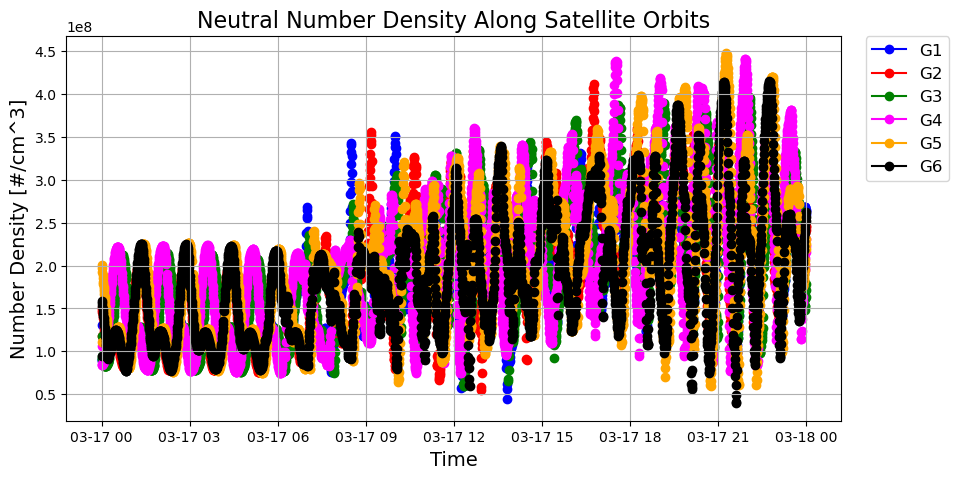

In [9]:
# Plotting

plt.figure(figsize=(10, 5))
for s in range(len(satellites)):
    plt.scatter(time_h_check,v_intp_all[s,:],color = sat_colors[s])
plt.title('Neutral Number Density Along Satellite Orbits', fontsize=16)
plt.ylabel('Number Density [#/cm^3]', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.legend(handles=legend_elements,fontsize='large',bbox_to_anchor =(1.15, 1.02),ncol=1)
plt.grid()


# plt.savefig('NND_GDC_3b_day1.png')

plt.show()

